# Proyecto GANs
## Aprendizaje Profundo
### Arturo Sirvent, Ángel Guevara

# Resumen

El objetivo del proyecto es aplicar un modelo generativo (redes GAN) a un dataset elegido por nosotros y hacerlo funcionar correctamente. 

El principal uso de las redes GAN es el de generar datos sintéticos que se parezcan a los datos reales de los que disponemos. Es por esto que se suelen usar las GANs como técnica de data augmentation. 

Las GANs están compuestas de un generador y un discriminador, que suelen ser redes neuronales y que compiten entre sí durante el entrenamiento. La misión del generador es crear datos parecidos a los reales mientras que la misión del discriminador es discernir si los datos que le llegan son reales o sintéticos. 

En particular, nosotros hemos elegido un dataset de imágenes de un tipo de pokemon llamado unowns. Estos son muy variados y cada uno de los subtipos se asocia con una letra del abecedario. 

Por tanto, en nuestro caso, el objetivo del trabajo será el de generar nuevos unowns a partir de los que ya existen a través del uso de las redes GAN. Además, para que el entrenamiento de la GAN sea más eficiente, usaremos técnicas de entremiento progresivo para que empiece aprendiendo las características generales de las imágenes y después comience a aprender detalles más concretos.

# Indice  

Seguiremos el siguiente guión durante el trabajo:

1º. Creación de un modelo sencillo como el visto en clase para el MNIST data set (baja resolución).

2º. Pruebas de entrenamiento de un modelo progresivo en el cual vayamos añadiendo capas tanto al Generador como al Discriminador, para que aprendan juntos y ademas pueda tener una mayor resolución.



In [ ]:
#librerias y common stuff

# To generate GIFs
!pip install -q imageio

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time
from skimage.transform import rescale, resize, downscale_local_mean
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import random_rotation
import tensorflow as tf
from IPython import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#carga de datos

init_data=np.load("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/unowns_original_separados_blackwhite.npy")
#init_data=np.load("unowns_original_separados_blackwhite.npy")
init_data=np.delete(init_data,(3),axis=0)


## 1º Pruebas de modelo sencillo (input pequeño)

#### Preparado datos

Los datos iniciales se encuentran normalizados entre 0 y 1, sin embargo a nosotros nos interesará normalizarlos entre -1 y 1. Además, reshapeamos las imágenes para que sean de 28x28 ya que las originales tienen menor resolución.

Para entrenar el modelo solo disponemos de las imágenes de los pokemon iniciales, que solo son 27 y, por tanto, muy pocas para entrenar el modelo. Por ello, modificaremos las imágenes para tener una cantidad mayor de datos de entrenamiento. En particular, realizaremos simetrías sobre el eje X y sobre el eje Y. De esta forma, acabamos con 27x2x2 posibles imágenes de entrenamiento, sin contar con que algunas de los datos iniciales eran simétricos respecto a alguno de los ejes y por tanto habría muestras repetidos. Este proceso lo podemos repetir tantas veces como queramos para tener más muestras de entrenamiento.


In [ ]:
#esto lo ponemos para las rotaciones aleatorias, pero al final ni lo usamos
#!pip install tensorflow_addons
#import tensorflow_addons as tfa

In [ ]:
init_data = (init_data*2 - 1.0) # Normalize the images to [-1, 1]
data=np.array([resize(i,(28,28)) for i in init_data])

#BUFFER_SIZE = 60000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(data[...,np.newaxis])

x_train = train_dataset.map(
    lambda image: (tf.image.convert_image_dtype(image, tf.float32))
).cache().map(
    lambda image: (tf.image.random_flip_left_right(image))
).map(
    lambda image: (tf.image.random_flip_up_down(image,))
#).map(
#    lambda image: (tfa.image.transform_ops.rotate(image, np.random.random()*np.pi, fill_value=-1))
).batch(BATCH_SIZE).repeat(BATCH_SIZE).shuffle(1000)

In [ ]:
#ESTO QUEDO DESCARTADO AL FINAL
#prueba de como queda la rotacion 
#rotated=random_rotation(tf.convert_to_tensor(data[1]),180)
plt.figure(figsize=(13,13))

for i in range(16):
  a=tfa.image.transform_ops.rotate(data[i], np.random.random()*np.pi, fill_value=-1)
  plt.subplot(4,4,i+1)
  plt.imshow(a)

#### Creación del modelo

A la hora de crear el modelo, tendremos que definir por un lado el generador y por otro lado el discriminador. La idea es que el generador tenga como entrada una variable ruidosa y que nos genere una imagen de 28x28, que después será la entrada del discriminador, cuya salida será un solo valor que nos indicará si la imagen es real o sintética.

Además, también calcularemos la función de pérdida para el generador y el discriminador. 

Una vez definidos los elementos de la GAN, desarrollamos funciones de entrenamiento. En concreto, una función de entrenamiento para una época en la que calculamos la imagen sintética y se la pasamos al discriminador, para luego calcular los gradientes y actualizarlos según la función de pérdida de entropía cruzada. Una vez hecho esto, tendremos otra función que repite lo anterior en función del número de épocas de entrenamiento que fijemos. 

In [ ]:
#generador
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(130,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

#discriminador
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [ ]:
#funciones para el entrenamiento

#ahora en principio no nos va a interesar guardar el modelo
"""
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
"""

EPOCHS = 200
noise_dim = 130
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

#guardamos las loss en una variable global
gen_loss_stage1=[]
disc_loss_stage1=[]



@tf.function
def train_step(images):
  global gen_loss_stage1
  global disc_loss_stage1

  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  
    # esto lo ponemos persistent=True para que nosea un unico gradiente el que sacaremos 
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    gen_loss_stage1.append(gen_loss.numpy())
    disc_loss_stage1.append(disc_loss.numpy())

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


def train(dataset, epochs):
  global gen_loss_stage1
  global disc_loss_stage1
  gen_loss_stage1=[]
  disc_loss_stage1=[]
  for epoch in range(epochs):
    start = time.time()

    for i,image_batch in enumerate(dataset):
      train_step(image_batch)
      #print(i)

    # Produce images for the GIF as we go
    #display.clear_output(wait=True)
    #generate_and_save_images(generator,epoch + 1,seed)

    # Save the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
    # checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  #display.clear_output(wait=True)
  #generate_and_save_images(generator,epochs,seed)
  
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 2 -1, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
#entrenamiento
generator = make_generator_model()
discriminator = make_discriminator_model()
train(x_train, EPOCHS)
np.save("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/stage1_disc_loss_128.npy",np.array(disc_loss_stage1))
np.save("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/stage1_gen_loss_128.npy",np.array(gen_loss_stage1))

#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Time for epoch 1 is 36.7393524646759 sec
Time for epoch 2 is 18.388111114501953 sec
Time for epoch 3 is 18.276920795440674 sec
Time for epoch 4 is 18.255895137786865 sec
Time for epoch 5 is 18.25094699859619 sec
Time for epoch 6 is 18.990405082702637 sec
Time for epoch 7 is 19.613168478012085 sec
Time for epoch 8 is 18.244662046432495 sec
Time for epoch 9 is 18.20944094657898 sec
Time for epoch 10 is 18.19626808166504 sec
Time for epoch 11 is 20.478280782699585 sec
Time for epoch 12 is 18.356852531433105 sec
Time for epoch 13 is 18.367805242538452 sec
Time for epoch 14 is 18.362278938293457 sec
Time for epoch 15 is 18.2732834815979 sec
Time for epoch 16 is 18.19809579849243 sec
Time for epoch 17 is 18.20307993888855 sec
Time for epoch 18 is 18.184353828430176 sec
Time for epoch 19 is 18.310919284820557 sec
Time for epoch 20 is 18.304575443267822 sec
Time for epoch 21 is 18.25361180305481 sec
Time for epoch 22 is 18.191298246383667 sec
Time for epoch 23 is 18.23605442047119 sec
Time for

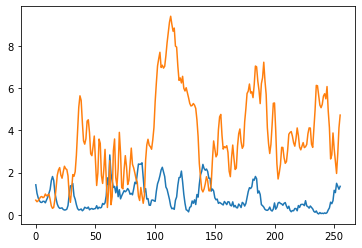

In [ ]:
#hacemos plot de los valores guardados de loss
plt.plot(disc_loss_stage1)
plt.plot(gen_loss_stage1)


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)
EPOCHS=60
train(x_train, EPOCHS)
np.save("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/stage1_2_disc_loss_128.npy",np.array(disc_loss_stage1))
np.save("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/stage1_2_gen_loss_128.npy",np.array(gen_loss_stage1))


Time for epoch 1 is 18.336673736572266 sec
Time for epoch 2 is 17.793896436691284 sec
Time for epoch 3 is 17.785279750823975 sec
Time for epoch 4 is 17.786746501922607 sec
Time for epoch 5 is 17.786660194396973 sec
Time for epoch 6 is 20.47407865524292 sec
Time for epoch 7 is 17.95149040222168 sec
Time for epoch 8 is 17.816794395446777 sec
Time for epoch 9 is 17.90952157974243 sec
Time for epoch 10 is 17.859766244888306 sec
Time for epoch 11 is 17.80901265144348 sec
Time for epoch 12 is 17.795957565307617 sec
Time for epoch 13 is 17.748252391815186 sec
Time for epoch 14 is 17.830641269683838 sec
Time for epoch 15 is 17.817731857299805 sec
Time for epoch 16 is 17.832797288894653 sec
Time for epoch 17 is 17.81756567955017 sec
Time for epoch 18 is 20.476325273513794 sec
Time for epoch 19 is 18.254891872406006 sec
Time for epoch 20 is 18.247055292129517 sec
Time for epoch 21 is 17.83624577522278 sec
Time for epoch 22 is 17.967928886413574 sec
Time for epoch 23 is 17.97335457801819 sec
Time

#### Gif

Finalmente, generamos un GIF animado para ver la evolución durante el entrenamiento de 16 muestras concretas. Se puede observar como a medida que avanza el entrenamiento las imágenes se van pareciendo cada vez más a las reales. De hecho, en muchas ocasiones se repiten algunos tipos de pokemons directamente, pero en otros casos podemos ver como está creando algunos nuevos que no aparecían en el dataset original pero que mantienen una cierta estructura y podrían ser perfectamente un subtipo del pokemon.

In [ ]:
"""
#creación final del gift etc


anim_file = 'dcgan_unos_mejor2_lowres.mp4'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 10*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

#descargar
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)
"""

"\n#creación final del gift etc\n\n\nanim_file = 'dcgan_unos_mejor2_lowres.mp4'\n\nwith imageio.get_writer(anim_file, mode='I') as writer:\n  filenames = glob.glob('image*.png')\n  filenames = sorted(filenames)\n  last = -1\n  for i,filename in enumerate(filenames):\n    frame = 10*(i**0.5)\n    if round(frame) > round(last):\n      last = frame\n    else:\n      continue\n    image = imageio.imread(filename)\n    writer.append_data(image)\n  image = imageio.imread(filename)\n  writer.append_data(image)\n\n#descargar\ntry:\n  from google.colab import files\nexcept ImportError:\n   pass\nelse:\n  files.download(anim_file)\n"

## 2º. Entrenamiento progresivo de una GAN  

[Artículo sobre el tema (arxiv)](https://arxiv.org/abs/1710.10196)


En este apartado, intentaremos entrenar la GAN de manera progresiva. Esto quiere decir que primero le pasaremos imágenes de poca resolución para que se aprenda la estructura general, y después iremos añadiendo capas para aumentar la resolución y que se fije en los detalles, en lugar de que la red tenga que aprenderlo todo de forma simultánea. 

Nosotros simplemente implementaremos 1 step de este tipo de entrenamiento. La idea será entrenar la GAN con imágenes de 28x28, guardarnos los pesos y después transmitirlos a la capas similares de la GAN que será entrenada con imágenes de resolución 56x56. De esta forma, no partimo de cero, sino que ya hemos aprendido ciertas características más generales.

In [ ]:
#cargamos los datos con una nueva resolución
data=np.array([resize(i,(56,56)) for i in init_data])

BUFFER_SIZE = 60000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(data[...,np.newaxis])#.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

x_train = train_dataset.map(
    lambda image: (tf.image.convert_image_dtype(image, tf.float32))
).cache().map(
    lambda image: (tf.image.random_flip_left_right(image))
).map(
    lambda image: (tf.image.random_flip_up_down(image,))
#).map(
#    lambda image: (tfa.image.transform_ops.rotate(image, np.random.random()*np.pi, fill_value=-1))
).batch(BATCH_SIZE).repeat(BATCH_SIZE).shuffle(1000)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
#Creamos el nuevo modelo y cargamos los viejos pesos
#generador
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(130,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 56, 56, 1)

    return model

#discriminador
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[56, 56, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))


    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [ ]:
generator2 = make_generator_model()
discriminator2 = make_discriminator_model()

In [ ]:
discriminator2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 dropout_2 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)        

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:

#transmision de pesos
for j in range(len(generator.layers)-1):
  generator2.layers[j].set_weights(generator.layers[j].get_weights())

for j in range(1,len(discriminator.layers)):
  discriminator2.layers[j+3].set_weights(discriminator.layers[j].get_weights())


In [ ]:
#funciones para el entrenamiento

"""
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
"""

EPOCHS = 200
noise_dim = 130
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

gen_loss_stage2=[]
disc_loss_stage2=[]

@tf.function
def train_step(images):
    global gen_loss_stage2
    global disc_loss_stage2

    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  
      # esto lo ponemos persistent=True para que nosea un unico gradiente el que sacaremos 
      generated_images = generator2(noise, training=True)

      real_output = discriminator2(images, training=True)
      fake_output = discriminator2(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      gen_loss_stage2.append(gen_loss.numpy())
      disc_loss_stage2.append(disc_loss.numpy())

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator2.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator2.trainable_variables))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator2.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator2.trainable_variables))


def train(dataset, epochs):
  global gen_loss_stage2
  global disc_loss_stage2
  gen_loss_stage2=[]
  disc_loss_stage2=[]
  for epoch in range(epochs):
    start = time.time()

    for i,image_batch in enumerate(dataset):
      train_step(image_batch)
      #print(i)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator2,epoch + 1,seed)

    # Save the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
    # checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator2,epochs,seed)
  
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 2 -1, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

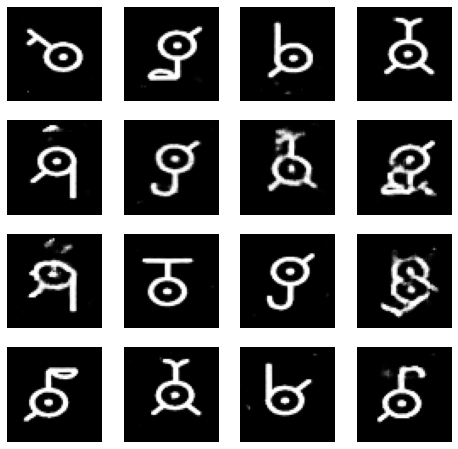

In [ ]:
train(x_train, EPOCHS)
np.save("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/stage2_disc_loss_128.npy",np.array(disc_loss_stage2))
np.save("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/stage2_gen_loss_128.npy",np.array(gen_loss_stage2))


In [ ]:
generator2.save("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/generador5.h5")
discriminator2.save("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/discriminator5.h5")
#generator2.save("generador4.h5")
#discriminator2.save("discriminator4.h5")

Finalmente, generamos unos datos aleatorios con 130 características y hacemos la predicción con el generador para ver las imágenes sintéticas que estamos generando. 

Observamos de nuevo lo comentado anteriormente. Generamos algunas imágenes que son practicamente iguales que las originales, y otras que sí que son nuevas y que mantienen la estructura general e innovan en algún aspecto. También hay alguna de las predicciones que no sale del todo bien. 

El hecho de que se repitan algunas de las imágenes se puede deber a que tan solo contábamos con 27 muestras iniciales. Por tanto, la variedad no es demasiada y puede deberse a eso que no haya tanta innovación.

In [ ]:
noise = tf.random.normal([100, 130])

pred=generator2(noise)

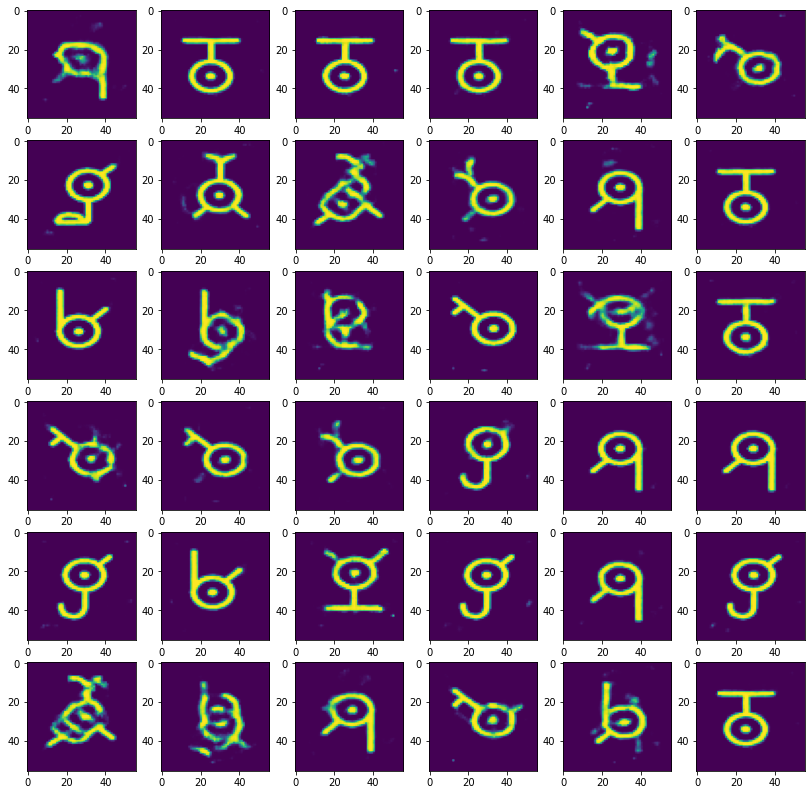

In [ ]:
plt.figure(figsize=(14,14))
pred=np.array(pred)
for i in range(36):
  plt.subplot(6,6,i+1)
  plt.imshow(pred[i,:,:,0])

In [ ]:
#creación final del gift etc

anim_file = 'dcgan_unos_progresive_lowres2_3.mp4'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 10*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

#descargar
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Plot de las funciones pérdida, todas juntas:**

In [ ]:
#cargamos los datos que hemos estado guardando en el entrenamiento
stage1_disc=np.load("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/stage1_disc_loss_128.npy")
stage1_gen=np.load("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/stage1_gen_loss_128.npy")
stage1_2_gen=np.load("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/stage1_2_gen_loss_128.npy")
stage1_2_disc=np.load("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/stage1_2_disc_loss_128.npy")
stage2_gen=np.load("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/stage2_gen_loss_128.npy")
stage2_disc=np.load("/content/drive/MyDrive/MasterCD/colabs/AprendProfund_master/know-GAN/stage2_disc_loss_128.npy")

Text(0.5, 0, 'Epochs')

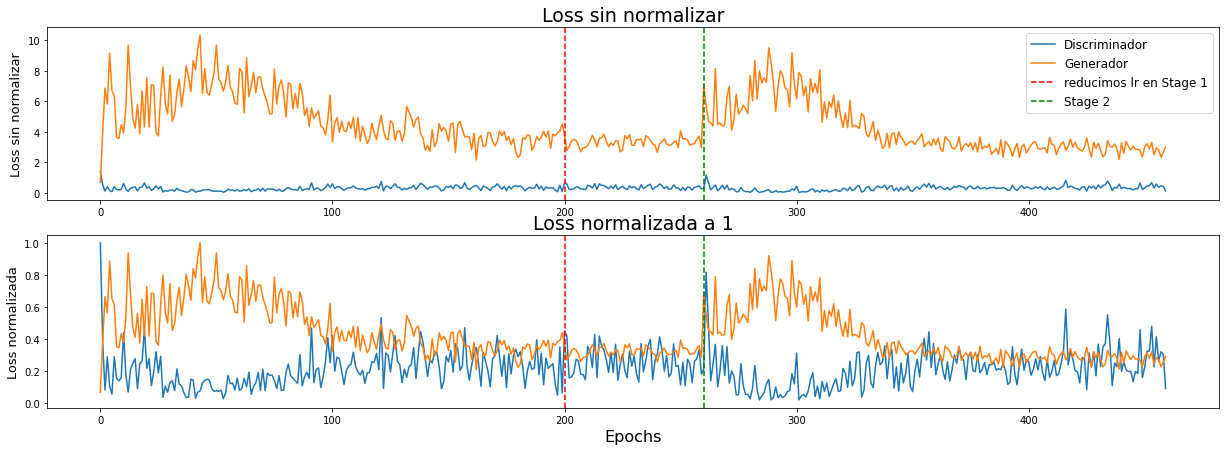

In [ ]:
#los datos son de 128 en 128 porque 128 era el BATCHSIZE

#vamos a representarlo sin que esten en la misma escala y estando normalizados a 1

#añadimos todos los datos a representar juntos
sin_normalizar_gen=np.concatenate([stage1_gen[::128],stage1_2_gen[::128],stage2_gen[::128]])
sin_normalizar_disc=np.concatenate([stage1_disc[::128],stage1_2_disc[::128],stage2_disc[::128]])

#si hay alguna que se va muchisimo la ponemos a un valor medio y ya 
sin_normalizar_disc[sin_normalizar_disc>2]=np.mean(sin_normalizar_disc[sin_normalizar_disc<2]) #esto es un poco chapuza pero es por claridad en los graficos

normal_gen=sin_normalizar_gen/max(sin_normalizar_gen)
normal_disc=sin_normalizar_disc/max(sin_normalizar_disc)

plt.figure(figsize=(21,7))
#hacemos plots de los datos de entrenamiento
plt.subplot(2,1,1)
ax=plt.gca()
plt.plot(sin_normalizar_disc,label="Discriminador")
plt.plot(sin_normalizar_gen,label="Generador")
plt.title("Loss sin normalizar",fontsize=19)
plt.ylabel("Loss sin normalizar",fontsize=13)
plt.axvline(200,c="r",ls='--',label="reducimos lr en Stage 1")
plt.axvline(260,c="g",ls='--',label="Stage 2")
plt.legend(fontsize=12)
plt.subplot(2,1,2,sharex=ax)
plt.plot(normal_disc,label="Discriminador")
plt.plot(normal_gen,label="Generador")
plt.title("Loss normalizada a 1",fontsize=19)
plt.axvline(200,c="r",ls='--',label="reducimos lr en stage 1")
plt.axvline(260,c="g",ls='--',label="Stage 2")
plt.ylabel("Loss normalizada",fontsize=13)
plt.xlabel("Epochs",fontsize=16)

#plt.legend(fontsize=12)

## Análisis de resultados y conclusiones 

Al generar unos cuantos elementos con el generador, podemos ver muchos pokemons de los que ya pertenecían al conjunto de entrenamiento, y otros que o bien son mezclas o deformaciones de estos. Para justificar esto, creemos que el escaso set de entrenamiento, y la limitada variedad de las formas, han limitado el "ingenio" del generador a adecuarse a las geometrías del set de imágenes reales. 

Nuestro objetivo en este trabajo realmente era implementar una GAN que generara pokemons desde ruido, e implementarla usando un crecimiento progresivo de la arquitectura de esta (https://arxiv.org/abs/1710.10196). Al implementar este crecimiento progresivo, (tras pruebas y errores, que por claridad del notebook no incluimos) hemos podido confirmar mejoras como:   

* Reducción en la cantidad de épocas necesarias para entrenar la red completa. Pues al partir de capas preentrenadas, los resultados de más alta resolución no necesitan empezar desde cero, tienen un punto de partida y eso acelera el proceso.  
* Aumento de la convergencia y la resolución posible. Una alta resolución no sería alcanzable si no fuera por métodos de entrenamiento progresivo, la red simplemente no sabría por donde empezar de la enorme cantidad de caminos disponibles. En nuestro caso, una imagen 56x56 no era posible con nuestros recursos (hardware), en un solo entrenamiendo, pero al segmentarlo en dos etapas, sí se logró la convergencia.  


Posibles mejoras:  
Tal como hemos mencionado, la "inventiva" del generador deja un poco que desear, posiblemente debido a la poca variedad en el conjunto de entrenamiento, lo cual genera un discriminador muy restrictivo frente a los patrones ligeramente nuevos. Para solucionar este problema proponemos tres soluciones:  

* La más obvia sería, aumentar el conjunto de entrenamiendo con nuevas muestra de pokemons del mismo estilo. (lamentablemente no hay más)

* Rotar el conjunto de entrenamiento. Al rotar y no solo reflejar (en X y en Y), obtenemos un conjunto mucho más rico de formas y patrones, que harían que el discriminador deba fijarse en características más "fundamentales" de las formas.  

* Limitar el discriminador y hacerlo más "tonto". Creemos que quizá limitando un poco la capacidad de discriminar, generador terminaría generando algunas formas más imaginativas, que aun así respeten la forma general de los pokemons.  
